In [1]:
# read pdfs
import fitz
from PIL import Image

# process images
import cv2 as cv
import numpy as np
from numpy import pi, sin, cos

# read csv
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Read all the images in the pdf created by camscanner
def getImagesFromPDF(file_name):
    img_lst = []
    doc = fitz.open(file_name)
    for i in range(len(doc)):
        for img in doc.get_page_images(i):
            xref = img[0]
            pix = fitz.Pixmap(doc, xref)
            if pix.n >= 5:       # this is CMYK (not GRAY or RGB) so convert to RGB first
                pix = fitz.Pixmap(fitz.csRGB, pix)

            mode = "RGBA" if pix.alpha else "RGB"
            img = np.array(Image.frombytes(mode, [pix.width, pix.height], pix.samples))
            if img.shape[0] > 270: # this is to skip the camscanner logo which is of shape (260, 260, 3)
                img_lst.append(("p%s-%s.png" % (i, xref), img))

            pix = None
    doc.close()

    return img_lst

# Fitting and Extraction Approach

## Houghlines approach

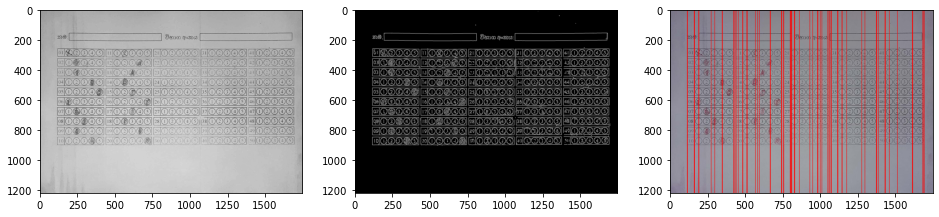

In [13]:
img_lst = getImagesFromPDF("grade-8-mcq-answer-sheets-1.pdf")
im = np.copy(img_lst[2][1])
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 20, 120, apertureSize=3)
lines = cv.HoughLines(edges, 1, np.pi/180, 200)

for line in lines:
    rho, theta = line[0]
    if -0.1<theta<+0.1:
        a = np.cos(theta)
        b = np.sin(theta)
        x0, y0 = a*rho, b*rho
        x1, y1 = int(x0 + 2000*(-b)), int(y0 + 2000*(a))
        x2, y2 = int(x0 - 2000*(-b)), int(y0 - 2000*(a))
        cv.line(im, (x1, y1), (x2, y2), (255,0,0), 2)

fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].imshow(gray, cmap=cm.gray)
ax[1].imshow(edges, cmap=cm.gray)
ax[2].imshow(im)

plt.show()

## Contour comparison approach

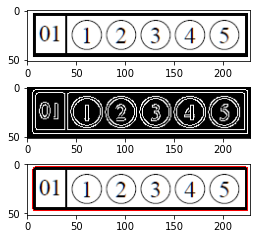

In [4]:
answer_row = cv.imread("assets/answer-row-1.png", cv.IMREAD_COLOR)
gray = cv.cvtColor(answer_row, cv.COLOR_BGR2GRAY)

edges = cv.Canny(gray, 20, 120, apertureSize=5, L2gradient=True)
contours, _ = cv.findContours(edges, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)
cont_img = np.copy(answer_row)
cont_img = cv.drawContours(cont_img, contours, 0, (255,0,0))

fig, ax = plt.subplots(3,1,figsize=(4,4))

ax[0].imshow(answer_row, cmap="gray")
ax[1].imshow(edges, cmap="gray")
ax[2].imshow(cont_img)

plt.show()

# Region Division Approach

In [3]:
correct_answers = pd.read_csv("correct-answers.csv")

## Functions

In [4]:
# visualization functions
def drawLine(rho, theta, img):
    a = cos(theta)
    b = sin(theta)
    x0, y0 = a*rho, b*rho
    x1, y1 = int(x0 + 2000*(-b)), int(y0 + 2000*(a))
    x2, y2 = int(x0 - 2000*(-b)), int(y0 - 2000*(a))
    cv.line(img, (x1, y1), (x2, y2), (255,0,0), 2)

# computational functions
def getIntersectionPoint(line1, line2):
    rho1, theta1 = line1[0], line1[1]
    rho2, theta2 = line2[0], line2[1]
    x = int((rho1*sin(theta2)-rho2*sin(theta1))/(sin(theta2-theta1)))
    y = int((rho2*cos(theta1)-rho1*cos(theta2))/(sin(theta2-theta1)))
    return x, y

In [46]:

# constants
mcq_grid_orig_dim = (1109.6, 517.6)
table_size = tuple(map(int, mcq_grid_orig_dim))
mcq_grid_cell_marg = 5
border_width = 2

# Trims the answers table
def extractMCQTable(mcq_sheet, showExtraction=False):
    # fine tune constants
    canny_min_threshold = 20
    canny_max_threshold = 80
    canny_apertureSize = 3
    hough_votes_vert_density = 200  # makes the vote count dependant to the image dimensions
    hough_votes_hori_density = 500  # makes the vote count dependant to the image dimensions
    hough_theta_max_variation_deg = 2

    hough_votes_vert = int(hough_votes_vert_density/mcq_sheet.shape[0]*900)
    hough_votes_hori = int(hough_votes_hori_density/mcq_sheet.shape[1]*1200)
    hough_theta_max_variation = hough_theta_max_variation_deg/180*np.pi

    gray = cv.cvtColor(mcq_sheet, cv.COLOR_BGR2GRAY)

    # detect houghlines
    edges = cv.Canny(gray, canny_min_threshold, canny_max_threshold, canny_apertureSize)
    horizontal_lines = cv.HoughLines(edges, 1, np.pi/180, hough_votes_hori, min_theta=np.pi/2-hough_theta_max_variation, max_theta=np.pi/2+hough_theta_max_variation)
    vertical_lines = cv.HoughLines(edges, 1, np.pi/180, hough_votes_vert, min_theta=0, max_theta=+hough_theta_max_variation)
    
    left_most_line, right_most_line, top_most_line, bottom_most_line = None, None, None, None
    max_val, min_val = 0, np.inf
    for line in horizontal_lines:
        if line[0][0]<min_val:
            left_most_line = line[0]
            min_val = line[0][0]
        if line[0][0]>max_val:
            right_most_line = line[0]
            max_val = line[0][0]
    max_val, min_val = 0, np.inf
    for line in vertical_lines:
        if line[0][0]<min_val:
            top_most_line = line[0]
            min_val = line[0][0]
        if line[0][0]>max_val:
            bottom_most_line = line[0]
            max_val = line[0][0]

    detected_img = mcq_sheet.copy()
    for line in (left_most_line, right_most_line, top_most_line, bottom_most_line):
        drawLine(line[0], line[1], detected_img)

    # get the corner points
    top_left = getIntersectionPoint(top_most_line, left_most_line)
    top_right = getIntersectionPoint(top_most_line, right_most_line)
    bottom_left = getIntersectionPoint(bottom_most_line, left_most_line)
    bottom_right = getIntersectionPoint(bottom_most_line, right_most_line)
    for point in (top_left, top_right, bottom_left, bottom_right):
        cv.circle(detected_img, point, 5, (0,0,255), -1)

    # apply homography
    contract_val = border_width
    H = cv.getPerspectiveTransform(np.float32((top_left, top_right, bottom_right, bottom_left)), np.float32((
        (-contract_val, -contract_val),
        (-contract_val, +contract_val+mcq_grid_orig_dim[1]),
        (+contract_val+mcq_grid_orig_dim[0], +contract_val+mcq_grid_orig_dim[1]),
        (+contract_val+mcq_grid_orig_dim[0], -contract_val)
    )))
    mcq_table = cv.warpPerspective(mcq_sheet, H, table_size)

    if showExtraction:
        fig, ax = plt.subplots(1,3, figsize=(16,8))
        ax[0].imshow(edges, cmap="gray")
        ax[1].imshow(detected_img)
        ax[2].imshow(mcq_table)

        plt.show()

    return mcq_table

In [74]:
# Divides the regions and read the data

def getQuestionRegion(mcq_table, table_size, question_number):
    assert type(question_number) == int
    assert question_number <= 50
    question_region_padding = 5
    row = (question_number-1)%10
    col = int((question_number-1)/10)
    region_w = table_size[0]/5
    region_h = table_size[1]/10
    question_region = mcq_table[int(row*region_h+question_region_padding):int((row+1)*region_h-question_region_padding), int(col*region_w+question_region_padding):int((col+1)*region_w-question_region_padding)]

    return question_region

def getSelectedAnswer(mcq_table, table_size, question_number, showRegions=False):
    question_number_width, answers_width = 30, 178
    answers_region_padding = 4
    question_region = getQuestionRegion(mcq_table, table_size, question_number)
    question_width = question_region.shape[1]
    answers_region = question_region[:,int(answers_region_padding+question_width*question_number_width/(question_number_width + answers_width)):-answers_region_padding]
    answer_width = answers_region.shape[1]/5

    # select the answer which has been colored (darkest)
    min_intensity, selected_answer = np.inf, 0
    for i in range(5):
        intensity = answers_region[:,int(i*answer_width):int((i+1)*answer_width)].sum()
        if intensity < min_intensity:
            min_intensity = intensity
            selected_answer = i+1
    
    if showRegions:
        fig, ax = plt.subplots(1,5)
        for i in range(5):
            ax[i].imshow(answers_region[:,int(i*answer_width):int((i+1)*answer_width)])
        plt.show()
    
    return selected_answer

def exportData(data, filename):
    out_str = ",selected_answers, correct, score\n"
    out_str += "\n".join(list(map(lambda x: ",".join(list(map(str, x))), data)))
    with open(filename, "w") as f:
        f.write(out_str)



## Test on a synthetic image

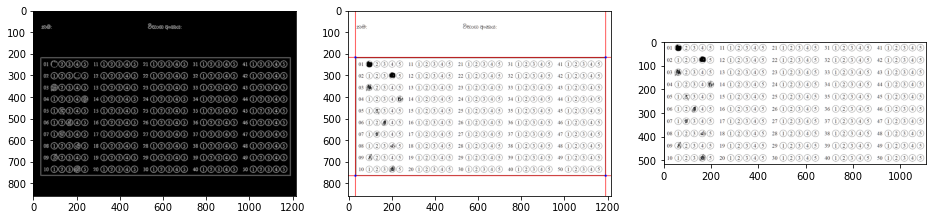

[('14152324141111111111', '10100000010001100000', 5)]


In [51]:
mcq_sheet = cv.imread("assets/mcq-sheet-2-marked.png", cv.IMREAD_COLOR)
mcq_table = extractMCQTable(mcq_sheet, showExtraction=True)
# load correct answers
mcq_sheet = cv.imread("assets/mcq-sheet-2-marked.png", cv.IMREAD_COLOR)

results = []
selected_answers = ""
correct = ""
score = 0
for row in correct_answers.iloc():
    q_num = row["question"]
    correct_answer = row["answer"]
    selected_answer = getSelectedAnswer(mcq_table, table_size, int(q_num))
    selected_answers += str(selected_answer)
    if selected_answer == correct_answer:
        correct += "1"
        score += 1
    else:
        correct += "0"
results.append((selected_answers, correct, score))
print(results)


## Test on the real images from pdf

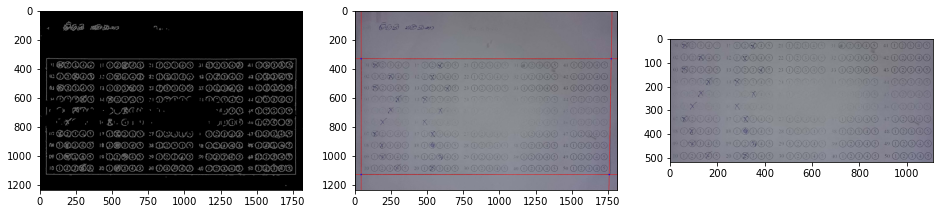

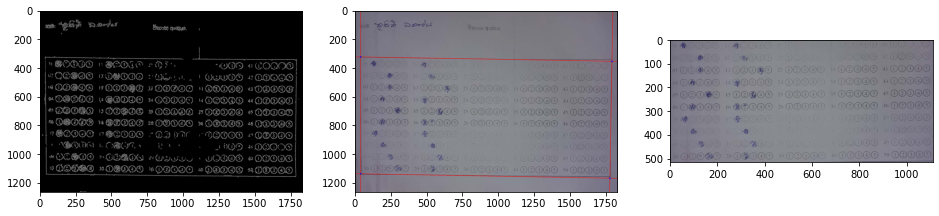

In [71]:
img_lst = getImagesFromPDF("grade-8-mcq-answer-sheets-2.pdf")
results = []

for i, img in enumerate(img_lst):
    mcq_sheet = img[1]
    mcq_table = extractMCQTable(mcq_sheet, showExtraction=True)
    selected_answers = ""
    correct = ""
    score = 0
    for row in correct_answers.iloc():
        q_num = row["question"]
        correct_answer = row["answer"]
        selected_answer = getSelectedAnswer(mcq_table, table_size, int(q_num))
        selected_answers += str(selected_answer)
        if selected_answer == correct_answer:
            correct += "1"
            score += 1
        else:
            correct += "0"
    results.append((i+1, selected_answers, correct, score))
    
exportData(results, "results.csv")
